In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

In [2]:
#read in data
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")
#preview data
#wego.head()

In [4]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return abs(row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

# create headway deviation percentable column
wego['HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [24]:
#establish columns for gapping, bunching, and acceptable headway values
wego['HDWY_GAPPING'] = 0
wego['HDWY_ACCEPTABLE'] = 0
wego['HDWY_BUNCHING'] = 0

In [25]:
#establish functions for populating headway columns
#Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 
#The generally accepted range of headway deviation is 50% to 150% of the scheduled headway 
#so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

def hdw_gapping(pct):
    if (pct < 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)
    
def hdw_acceptable(pct):
    if abs(pct) <= 50:
        return int(1)
    else:
        return int(0)
    
def hdw_bunching(pct):
    if (pct > 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)

In [26]:
# #establish functions for populating headway columns

# def hdw_gapping(pct):
#     if pct > 150:
#         return int(1)
#     else:
#         return int(0)
    
# def hdw_acceptable(pct):
#     if (pct >=50) & (pct <= 150):
#         return int(1)
#     else:
#         return int(0)
    
# def hdw_bunching(pct):
#     if pct < 50:
#         return int(1)
#     else:
#         return int(0)

In [27]:
#execute functions and apply 0/1 values to columns
wego['HDWY_BUNCHING'] = wego['HDWY_DEV_PCT'].apply(hdw_bunching)
wego['HDWY_ACCEPTABLE'] = wego['HDWY_DEV_PCT'].apply(hdw_acceptable)
wego['HDWY_GAPPING'] = wego['HDWY_DEV_PCT'].apply(hdw_gapping)

In [47]:
wego.HDWY_GAPPING.sum()

17999

In [48]:
wego.HDWY_ACCEPTABLE.sum()

225918

In [49]:
wego.HDWY_BUNCHING.sum()

21973

In [50]:
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [51]:
wego.DATE_TRIP.nunique()

67370

### 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like? 

In [52]:
#overall on time performance
round(wego.ADJUSTED_ONTIME_COUNT.value_counts()[1]/len(wego)*100,2)

77.08

77.08% of trips are on time.

In [53]:
#perfect_trips
perfect_trips = wego.groupby('DATE_TRIP')[['ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']].sum()
perfect_trips = perfect_trips[(perfect_trips.ADJUSTED_EARLY_COUNT == 0) & (perfect_trips.ADJUSTED_LATE_COUNT == 0)]

perfect_count = len(perfect_trips)

percent_perfect = perfect_count/(wego.DATE_TRIP.nunique())*100

print('Number of perfect trips: ' + str(perfect_count))
print('Percentage of perfect trips: ' + str(percent_perfect))


Number of perfect trips: 40843
Percentage of perfect trips: 60.624907228736824


In [37]:
## Per Dibran - use adjusted fields and newly calculated hdwy to chart performance
#distribution of headway and adherence
ad_stddev = np.std(wego.ADHERENCE)
ad_mean = wego.ADHERENCE.mean()
ad_min = ad_mean-(ad_stddev*3)
ad_max = ad_mean+(ad_stddev*3)

hdw_stddev = np.std(wego.HDWY_DEV)
hdw_mean = wego.HDWY_DEV.mean()
hdw_min = hdw_mean-(hdw_stddev*3)
hdw_max = hdw_mean+(hdw_stddev*3)

In [ ]:
# wego.ADHERENCE.describe()

In [45]:
#distributions of adherence
adherence_cats = wego[wego['ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT']].sum()
# adherence_cats.plot(kind='hist')
# adherence_cats.set(title='Adherence Distribution by Category', xlabel='Category',  ylabel='Count of Stops')
# sns.histplot(data=adherence_cats)

KeyError: ('ADJUSTED_EARLY_COUNT', 'ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT')

[Text(0.5, 1.0, 'Adherence Distribution Excluding Outliers'),
 Text(0.5, 0, 'Adherence'),
 Text(0, 0.5, 'Count of Stops')]

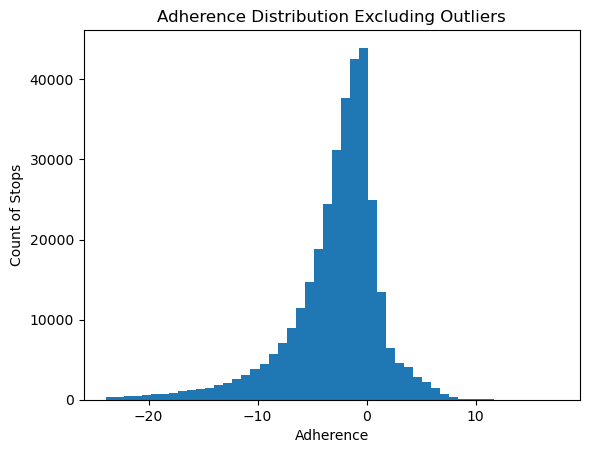

In [38]:
#distributions of adherence deviation
adherence_hist = wego[wego['ADHERENCE'].between(ad_min, ad_max, inclusive='both')]['ADHERENCE'].plot(kind='hist', bins=50)
adherence_hist.set(title='Adherence Distribution Excluding Outliers', xlabel='Adherence',  ylabel='Count of Stops')

In [ ]:
wego.HDWY_DEV.describe()

In [ ]:
#distributions of headway deviation
adherence_hist = wego[wego['HDWY_DEV'].between(hdw_min, hdw_max, inclusive='both')]['HDWY_DEV'].plot(kind='hist', bins=50)
adherence_hist.set(title='Headway Distribution Excluding Outliers', xlabel='Headway in Minutes',  ylabel='Count of Stops')

### 2. How does direction of travel, route, or location affect the headway and on-time performance?

In [ ]:
wego.columns

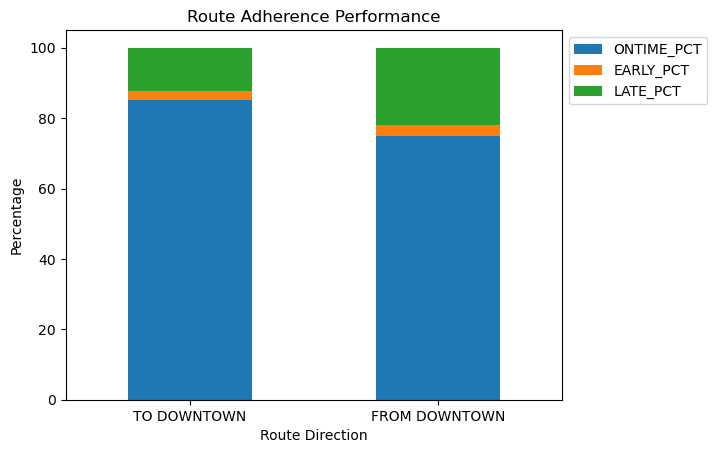

In [107]:
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [109]:
# #initial adherence by direction using count of stops
# #headyway and adherence by route direction
# ad_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().plot(kind='bar', stacked=True)
# ad_chart.set(title='Route Direction Adherence by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# ad_chart.legend(bbox_to_anchor=(1, 1))

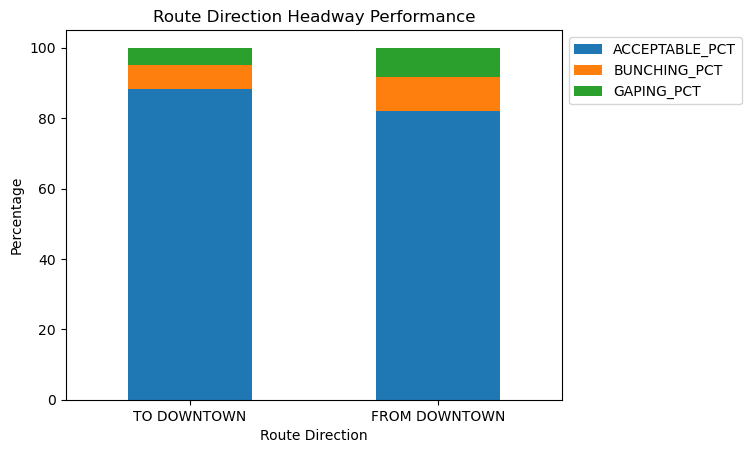

In [108]:
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Direction Headway Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [110]:
# #initial headway by route direction using count of stops
# hdw_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().plot(kind='bar', stacked=True)
# hdw_chart.set(title='Route Direction Headway by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# hdw_chart.legend(bbox_to_anchor=(1, 1))


In [113]:
wego.groupby('ROUTE_DIRECTION_NAME')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_DIRECTION_NAME,,
FROM DOWNTOWN,-3.960287,0.579990
TO DOWNTOWN,-2.321804,0.447773


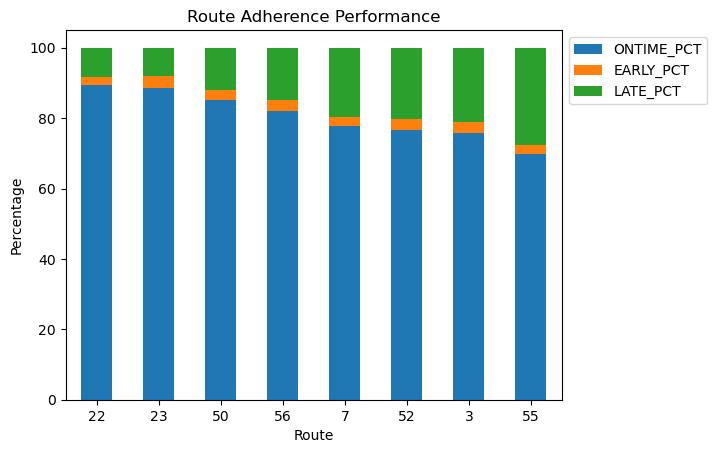

In [102]:
#break down stops by percentage of category
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [98]:
# #initial adherence by route ID using count of stops
# #aherence by route ID
# rte_adh_chart = wego.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True)
# rte_adh_chart.set(title='Adherence by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_adh_chart.legend(bbox_to_anchor=(1, 1))

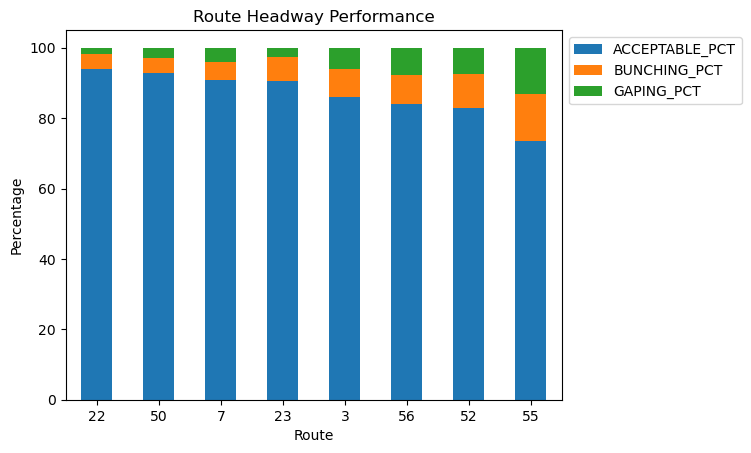

In [103]:
#break down stops by percentage of category - headway
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Headway Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [105]:
#intitial headway by route ID using count of stops
# #headway by route ID
# rte_hdw_chart = wego.groupby('ROUTE_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True)
# rte_hdw_chart.set(title='Headway by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [61]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


In [91]:
#adherence by stop location
#loc_adh_chart.figure(figsize=(12,12))
loc_adh_chart = wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True, width=0.6)
loc_adh_chart.set(title='Adherence by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
loc_adh_chart.legend(bbox_to_anchor=(1, 1))

KeyError: 'ADJUSTED_ONTIME_COUNT'

[Text(0.5, 1.0, 'Headway by Stop Location'),
 Text(0.5, 0, 'Stop ID'),
 Text(0, 0.5, 'Count of Stops')]

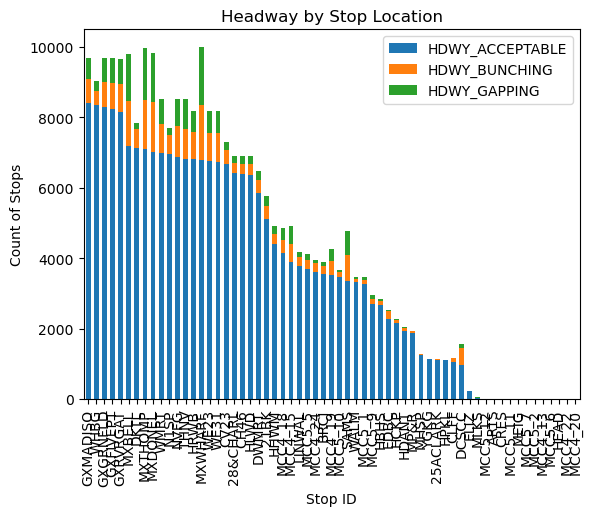

In [114]:
#use box plot
#chart with location, count, mean.
#headway by stop location
loc_hdw_chart = wego.groupby('TIME_POINT_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True, width=0.6)
loc_hdw_chart.set(title='Headway by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
# loc_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [104]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
21BK,-4.180070,0.398813
25ACLARK,1.458553,0.551163
28&CHARL,-2.838419,0.198635
ARTS,-4.233489,1.450000
BRCJ,-3.864808,1.161457
...,...,...
WE23,-3.929729,0.531195
WE31,-3.945215,0.522487
WHBG,-3.586182,0.330427


#### Buses headed into downtown are more timely than outbound buses; route 22 is the most timely

### 3. How does time of day or day of week affect headway and on-time performance?

##### whisker plots for number three
#### number 4 - group by operator, what percent of stops are acceptable vs total stops


In [ ]:
wego.info(verbose=True, show_counts=True)

In [ ]:
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [ ]:
# Create depart time column
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.hour)

In [ ]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

In [ ]:
# use Grouper to group by hour
adherence_by_time = (clean_dept_time.groupby('HOUR')
                     [['ADHERENCE', 'HDWY_DEV']]
                    .mean().reset_index())
adherence_by_time

In [ ]:
# use Grouper to group by day
adherence_by_day = (clean_dept_time.groupby('WEEKDAY')
                     [['ADHERENCE', 'HDWY_DEV']]
                     .mean().reset_index())
adherence_by_day

4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

In [ ]:
wego.columns

In [35]:
wego.groupby('OPERATOR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum()

,HDWY_ACCEPTABLE,HDWY_BUNCHING,HDWY_GAPPING,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
OPERATOR,,,,,,
0,0,0,0,0,0,1
56,2,0,0,0,0,3
235,7,2,0,1,5,6
244,13,4,3,0,5,20
301,16,10,4,1,17,19
...,...,...,...,...,...,...
3149,52,4,0,4,8,76
3156,220,5,5,0,71,219
3165,16,8,0,0,20,12


In [ ]:
wego.head()

In [ ]:
Q4 = wego[wego['HDWY_ACCEPTABLE']]
Q4

5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [ ]:
wego['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(wego['ACTUAL_DEPARTURE_TIME'])

In [ ]:
wego["DEPART_TIME"] = wego.ACTUAL_DEPARTURE_TIME.dt.time

In [ ]:
hr_volume = (wego
    .groupby(pd.Grouper(key = 'DEPART_TIME',     # point it to your datetime column
                     freq = '1h',               # How much do you want to group together values?
                     origin = 'epoch'           # This will start times at midnight of 1970-01-01. 
                                                # This ensures that we are starting our first grouped period on the hour
                    ))
     ['ADHERENCE'].mean()
#     .nunique() #shows only unique scooters being used during that time (if scooter is used more than once in an hour)
#     .nlargest(10)
 #.sort_values(ascending = False)
     .reset_index())
#  .head(20)



**Stretch Goals:**  

6. How much impact does being late or too spaced out at the first stop have downstream?  
7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more dwell time at the beginning of a trip lead to more stable headways (lower values for % headway deviation)? Do trips with longer **scheduled** layover time have more stable headway values?  
8. What is the relationship between distance or time traveled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has traveled?